In [274]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

In [275]:
theta_true = torch.Tensor([0])
prior = torch.distributions.Normal(0, 5)
N=100

# Observing 2 random variable $ z_1, z_2 \sim \mathcal{N}(\theta, 1) $

In [276]:

#Say we observe z1, z2
zi = torch.distributions.Normal(theta_true, 1).sample((N,)).squeeze().tolist()
z1, z2 = zi[0], zi[1]

In [277]:

def posterior_z(theta, z1, z2):
    def improper_posterior_z(theta, z1=z1, z2=z2):
        likelihood_part = -(np.square(theta-z1) + np.square(theta-z2))/2
        prior_part = np.square(theta)/25
        res = np.exp(likelihood_part)*np.exp(prior_part)
        return res
    Z_z1_z2, eps = integrate.quad(improper_posterior_z,-15,15) #Integrale of p_impropre(θ|z1,z2)
    return improper_posterior_z(theta, z1, z2)/Z_z1_z2


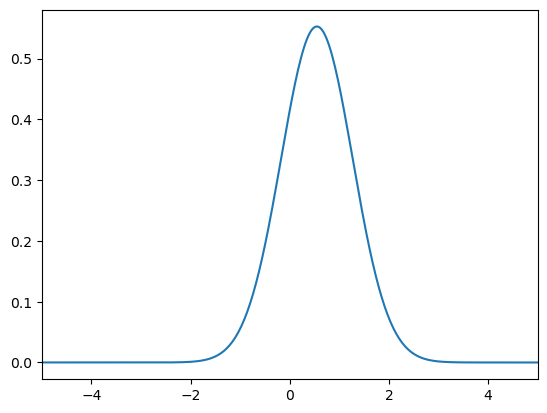

In [278]:
theta_grid = np.linspace(-15,15,1000)
eval_post = [posterior_z(theta, z1, z2) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post)
plt.xlim(left=-5,right=5)
plt.show()

# Say we observed the mean of two random variables, $x= \frac{1}{2}(z_1 + z_2) $

In [279]:
x = (z1 + z2)/2

In [280]:
def posterior_x(theta, x):
    def improper_posterior_x(theta, x=x):
        likelihood_part = -np.square(theta - x)
        prior_part = np.square(theta)/25
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x, eps = integrate.quad(improper_posterior_x, -15, 15)
    return improper_posterior_x(theta,x)/z_x

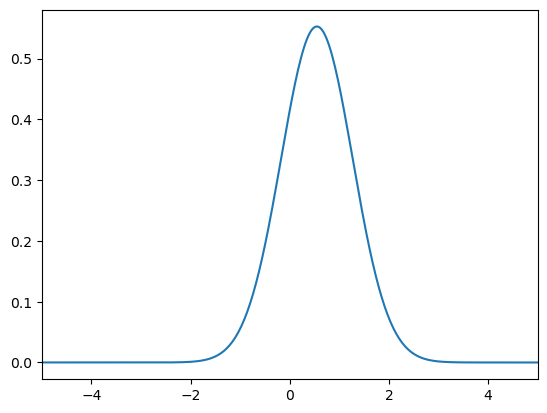

In [281]:
eval_post_x = [posterior_x(theta, x) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_x)
plt.xlim(left=-5,right=5)
plt.show()

# Say we observed the mean of N random variables

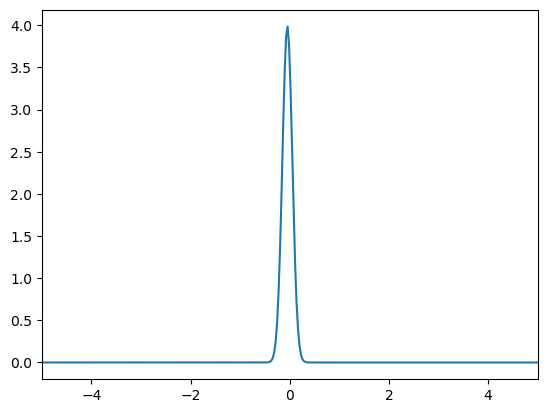

In [282]:
x = np.mean(zi)


def posterior_x_N(theta,x):
    def impropoer_posterior_x_N(theta, x=x):
        likelihood_part = -N*np.square(theta -x)/2
        prior_part = -np.square(theta)/25
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x_n, eps = integrate.quad(impropoer_posterior_x_N,-15, 15)
    return impropoer_posterior_x_N(theta,x)/z_x_n



eval_post_x_n = [posterior_x_N(theta, x) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_x_n)
plt.xlim(left=-5,right=5)
plt.show()

# Suppose we observed the mean and the variance of N random variables

In [283]:
x1 = np.mean(zi)
x2 = np.var(zi)
np.abs(x1 - theta_true)

tensor([0.0504])

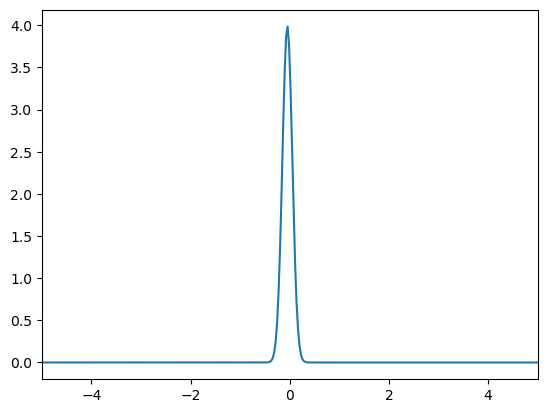

In [284]:
def posterior_summaries(theta, x1, x2):
    def impropoer_posterior_summaries(theta,x1=x1,x2=x2):
        likelihood_x1_part = -N*np.square(theta - x1)/2
        likelihood_x2_part = -N*np.square(1 - x2)
        prior_part = -np.square(theta)/25
        return np.exp(likelihood_x1_part)*np.exp(likelihood_x2_part)*np.exp(prior_part)
    z_summaries, eps = integrate.quad(impropoer_posterior_summaries, -15, 15)
    return impropoer_posterior_summaries(theta,x1,x2)/z_summaries

eval_post_summaries = [posterior_summaries(theta, x1, x2) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_summaries)
plt.xlim(left=-5,right=5)
plt.show()

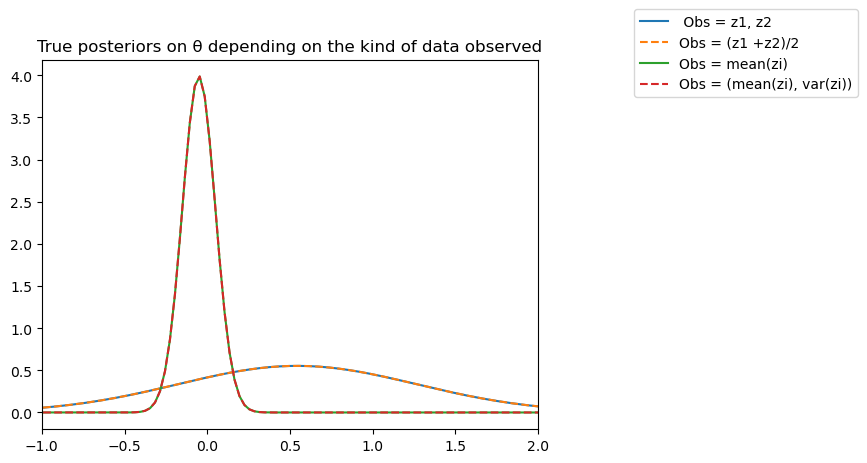

In [285]:
fig = plt.figure()
plt.xlim(left=-1, right=2)
plt.plot(theta_grid, eval_post, label=" Obs = z1, z2")
plt.plot(theta_grid, eval_post_x, label="Obs = (z1 +z2)/2", linestyle='dashed')
plt.plot(theta_grid, eval_post_x_n, label="Obs = mean(zi)")
plt.plot(theta_grid, eval_post_summaries, label="Obs = (mean(zi), var(zi))", linestyle="dashed")
fig.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("True posteriors on θ depending on the kind of data observed")
plt.show()


As expected the last 2 methods yield similar results, as are the first two.

# Now let us compare these true posteriors to the estimations using SBI

Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

 Neural network successfully converged after 22 epochs.

C:\Users\mmmat\AppData\Local\Temp\ipykernel_14564\2995720402.py:96: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


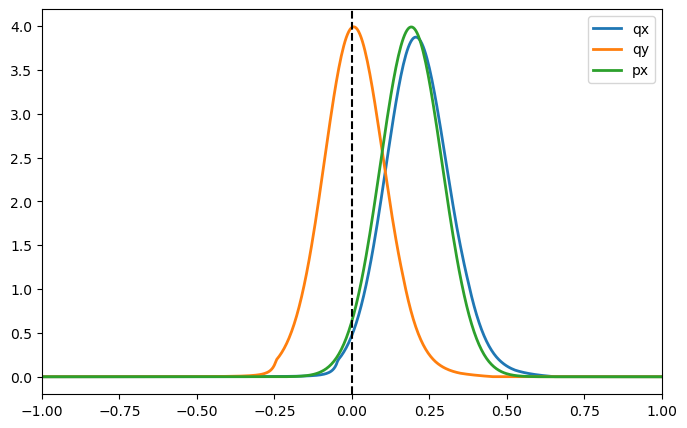

In [317]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial

torch.manual_seed(42)

# define the prior over theta
prior = torch.distributions.Normal(
    loc=torch.tensor([0.0]), scale=torch.tensor([5.0])
)

# define the model to work with
def gaussian(theta, sigma, summ_stats):
    zx = torch.distributions.Normal(loc=theta, scale=sigma).sample((100,))
    sx = {}
    sx['mean'] = zx.mean()
    sx['var'] = zx.var()
    ss = []
    for st in summ_stats:
        ss.append(sx[st])
    return torch.tensor(ss)

# choose which summary statistics to consider
ss = ['mean', 'var']

# fix the standard deviations of the zx
sigma_x = 1.0

# make sure that prior and model are in SBI format
simulator, prior = prepare_for_sbi(
    partial(gaussian, sigma=sigma_x, summ_stats=ss),
    prior)

# instantiate the density estimator to use
density_estimator_build_fun = posterior_nn(
    model="nsf",
    hidden_features=40,
    num_transforms=5,
    num_bins=10,
    num_blocks=2
)

# instantiate an inference object
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)

# generate the training dataset with simulations
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=50_000)
# store the simulations in the inference object
inference = inference.append_simulations(theta, x)

# train the neural spline flow on the simulated data
density_estimator = inference.train(training_batch_size=256,
                                    stop_after_epochs=5,
                                    max_num_epochs=50,
                                    learning_rate=5e-4,
                                    validation_fraction=0.10)

# build the posterior estimator object
posterior = inference.build_posterior(density_estimator)

# choose the ground truth value of the input parameter
mu = torch.tensor([0.0]).view(1,-1)

# generate observations
x = gaussian(theta=mu, sigma=sigma_x, summ_stats=ss)

sigma_y = np.sqrt(2)
y = gaussian(theta=mu, sigma=sigma_y, summ_stats=ss)

# generate samples via rejection sampling
tt = torch.linspace(-2, 2, 1000).view(-1, 1)
qx = torch.exp(posterior.log_prob(tt, x=x))
qy = torch.exp(posterior.log_prob(tt, x=y))

tt = np.linspace(-2, +2, 1000)
px = np.exp(-50*(tt - x[0].item())**2) * np.exp(-tt**2/50)
dt = tt[1] - tt[0]
Z = np.sum(px * dt)
px = px / Z

fig, ax = plt.subplots(figsize=(8, 5))
bins = torch.linspace(-2, +2, 100)
dx = bins[1] - bins[0]
ax.plot(tt, qx, lw=2.0, c='C0', label='qx')
ax.plot(tt, qy, lw=2.0, c='C1', label='qy')
ax.plot(tt, px, lw=2.0, c='C2', label='px')
ax.axvline(x=mu.item(), ls='--', c='k')
ax.set_xlim([-1, +1])
ax.legend()
fig.show()

In [287]:
import zuko
import lampe.inference
import lampe.utils
from tqdm.notebook import tqdm_notebook as tqdm
from lampe.utils import GDStep

from itertools import islice
from lampe.data import JointLoader

In [288]:
M = 50_000

def build_nsf(features, context):
    """Callable to instanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)

def simulator_lampe(theta):
    sample = torch.distributions.Normal(theta, 1).sample((100,))
    return sample.mean()

nsf = lampe.inference.NPE(theta_dim = 1, x_dim=1, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
theta = prior.sample((M, ))
x = torch.stack([gaussian(theta_i,1,["mean"]) for theta_i in theta])

def train_flow(flow, loss, theta, x):
    
    optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)
    data = lampe.data.JointDataset(theta, x)
    loader = lampe.data.DataLoader(data, 256)
    nsf.train()

    with tqdm(range(50), unit='epoch') as tq:
        for epoch in tq:
            for theta_batch, x_batch in loader:
                losses = loss(theta_batch, x_batch)
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
            tq.set_postfix(loss=losses.mean().item())
    flow.eval()
    return flow

nsf = train_flow(nsf,loss,theta,x)

  0%|          | 0/50 [00:00<?, ?epoch/s]

In [289]:
x_star = gaussian(theta_true,1,["mean"])
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (N,))

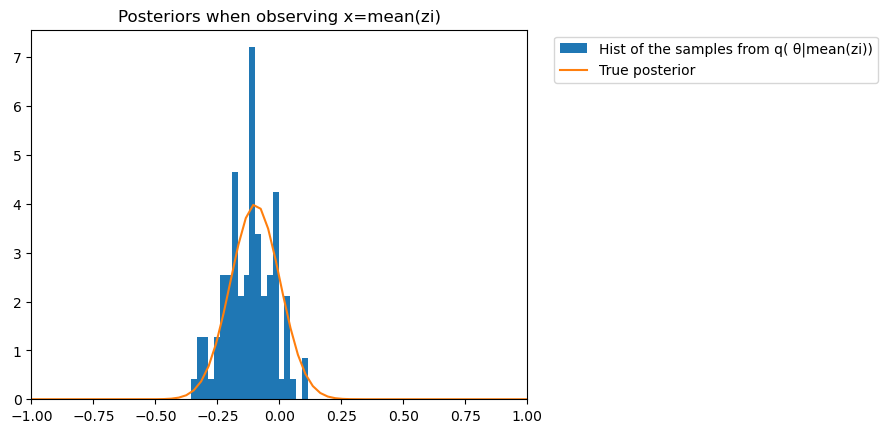

In [290]:
plt.hist(samples.numpy(), density=True, bins=20, label="Hist of the samples from q( θ|mean(zi))")
eval_post_summaries = [posterior_x_N(theta, x_star.numpy()) for theta in theta_grid]
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-1,right=1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Posteriors when observing x=mean(zi)")
plt.show()

In [291]:
nsf = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
theta = prior.sample((M, ))
x = torch.stack([gaussian(theta_i,1,["mean","var"]) for theta_i in theta])
nsf = train_flow(nsf,loss,theta,x)



  0%|          | 0/50 [00:00<?, ?epoch/s]

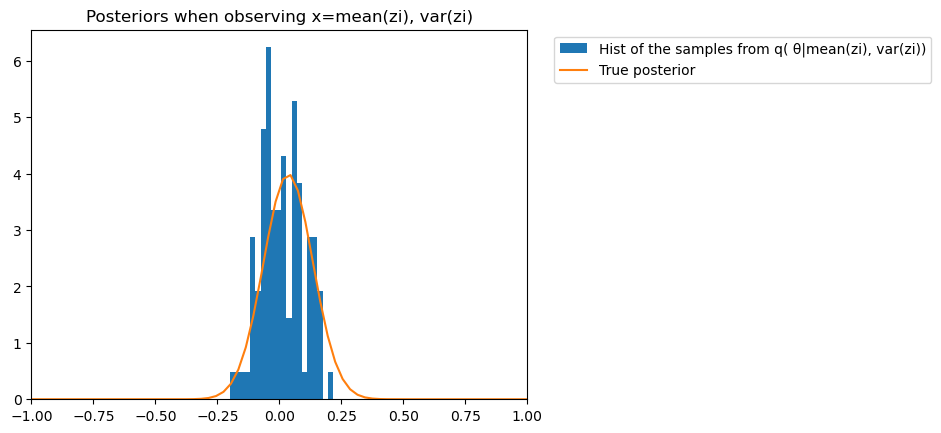

In [292]:
x_star = gaussian(theta_true,1,["mean","var"])
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (N,))
    
plt.hist(samples.numpy(), density=True, bins=20, label="Hist of the samples from q( θ|mean(zi), var(zi))")
eval_post_summaries = [posterior_summaries(theta, x_star[0].item(), x_star[1].item()) for theta in theta_grid]
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-1,right=1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Posteriors when observing x=mean(zi), var(zi)")
plt.show()

  0%|          | 0/50 [00:00<?, ?epoch/s]

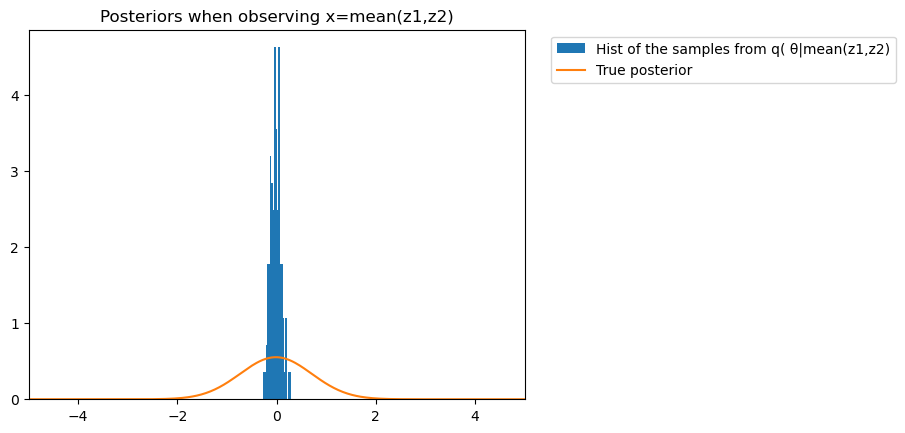

In [316]:
nsf = lampe.inference.NPE(theta_dim = 1, x_dim=1, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
theta = prior.sample((M, ))
x = torch.stack([gaussian(theta_i,1,["mean"]) for theta_i in theta])
nsf = train_flow(nsf,loss,theta,x)

x_star = gaussian(theta_true,1,["mean"])
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (N,))
  
plt.hist(samples.numpy(), density=True, bins=20, label="Hist of the samples from q( θ|mean(z1,z2)")
eval_post_summaries = [posterior_x(theta, x_star.item()) for theta in theta_grid]
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-5,right=5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Posteriors when observing x=mean(z1,z2)")
plt.show()
